## Import Libraries

In [27]:
import cv2
import os
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Import Env File

In [28]:
from dotenv import load_dotenv  

load_dotenv()
datasets_path = os.getenv('DATASET_PATH')
models_path = os.getenv('MODELS_PATH')

## Parameters

In [29]:
classes = ['jogja', 'pekalongan']
image_size = (224, 224) 
test_split_ratio = 0.2

## GLCM Function

In [30]:
def extract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation]

## Load The Dataset and Extract The Features

In [31]:
features = []
labels = []
for class_idx, class_name in enumerate(classes):
    folder = f'{datasets_path}/{class_name}'
    for img_name in os.listdir(folder):
        img_path = os.path.normpath(os.path.join(folder, img_name))
        image = cv2.imread(img_path)
        image = cv2.resize(image, image_size)
        glcm_features = extract_glcm_features(image)
        features.append(glcm_features)
        labels.append(class_idx)
        
features = np.array(features)
labels = np.array(labels)

## Train Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=test_split_ratio, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  
X_test = scaler.transform(X_test)        

In [42]:
# Melihat 10 baris pertama dari X_train
print("X_train (10 baris pertama):")
print(X_train[:10])

X_train (10 baris pertama):
[[-0.66081284 -1.37357232  3.12460553  4.53538344  1.08163402]
 [-0.96559246 -0.92811691 -0.52130102 -0.48103771  1.10842699]
 [-0.44904431 -0.18338522 -0.45765123 -0.43383682 -1.51736725]
 [-0.61315426 -0.40072364 -0.53187188 -0.44956845 -0.36078879]
 [-0.12222513  0.53465569 -0.82632463 -0.51775253 -0.98085405]
 [-0.44061768  0.1738414  -0.84456357 -0.51441655 -0.42767732]
 [ 0.32828566  0.69650522 -0.70172646 -0.51380444 -0.09202839]
 [ 0.9832357   0.79262275 -0.49325751 -0.4873794   0.00807112]
 [-0.99065618 -0.73779227 -0.73111919 -0.48975397 -0.0920996 ]
 [ 0.7840571   0.45584432 -0.10557741 -0.45573731  0.08127248]]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [55]:
# Melihat 10 baris pertama dari X_train_pca
print("X_train_pca (10 baris pertama):")
print(X_train_pca[:10])

X_train_pca (10 baris pertama):
[[-4.59572167  3.3358271  -0.95025894]
 [-0.98357592 -1.49674444  0.48056532]
 [ 0.80120233 -0.57755045 -1.37159081]
 [ 0.11698664 -0.93297062 -0.50683115]
 [ 1.24971104 -0.47718829 -0.60781863]
 [ 0.67918144 -0.84054295 -0.35069768]
 [ 1.04495133 -0.24406199  0.35906688]
 [ 1.21661861  0.23529495  0.73244327]
 [-0.23455005 -1.3958724  -0.49110412]
 [ 0.740706    0.21974759  0.61994348]]


## Train SVM

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=5)
grid.fit(X_train_pca, y_train)
print("Best params:", grid.best_params_)

Best params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


In [59]:
from sklearn.svm import SVC

# Gunakan parameter terbaik dari GridSearchCV
best_model = SVC(C=1, kernel='rbf', gamma='auto')
best_model.fit(X_train_pca, y_train)


SVC(C=1, gamma='auto')

## Evaluates

In [ ]:
# Evaluasi model
y_pred = best_model.predict(X_test_pca)

from sklearn.metrics import classification_report, confusion_matrix
print("Akurasi:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Akurasi: 0.575
              precision    recall  f1-score   support

           0       0.60      0.57      0.59        21
           1       0.55      0.58      0.56        19

    accuracy                           0.57        40
   macro avg       0.57      0.58      0.57        40
weighted avg       0.58      0.57      0.58        40



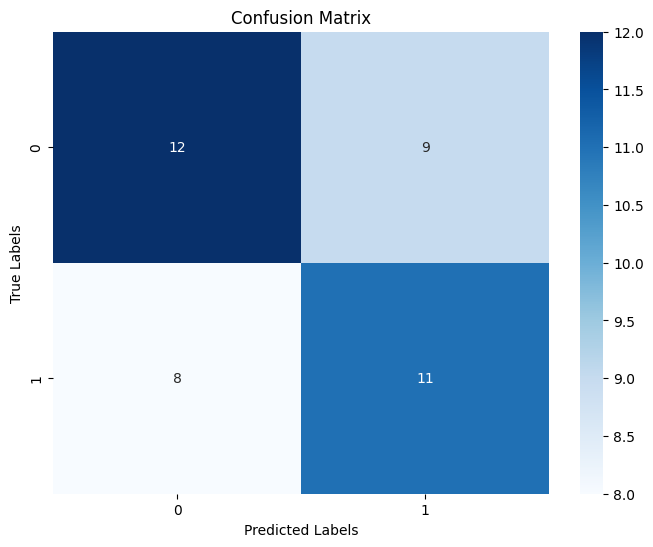

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualisasikan dengan heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


## Save The Model

In [61]:
from joblib import dump

# Simpan model ke file
dump(best_model, models_path+'/svm_glcm_model.joblib')
print("Model berhasil disimpan ke svm_glcm_model.joblib")

Model berhasil disimpan ke svm_glcm_model.joblib
